In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from new_aeb_gplvm import *
from utils.data_generator import DataGenerator
from utils.myutils import Utils
from tqdm import trange
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
import json
import os
import pandas as pd
utils = Utils()
import time

2023-12-01 01:55:13.499567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 01:55:13.587049: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
def create_dataframe(experiment):
    datagenerator = DataGenerator()
    
    noise_type = (
        None if experiment["noise_type"] == "normal" else experiment["anomaly_type"]
    )  # irrelevant,duplicated
    anomaly_type = (
        None if experiment["anomaly_type"] == "normal" else experiment["anomaly_type"]
    )  # cluster,global,local,dependency

    datagenerator.dataset = experiment["dataset"]
    data = datagenerator.generator(
        la=1.00,
        realistic_synthetic_mode=anomaly_type,
        noise_type=noise_type,
        noise_ratio=float(experiment["noise_ratio"]),
        stdscale=True,
        minmax=False,
    )

    Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
    Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
    lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
    lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

    return Y_train, Y_test, lb_train, lb_test

In [5]:
# EXPERIMENTS_FILE = "experiments/refine/002_complete_normal_study.json"
# OUTPUT_FILE = "experiments/refine/002_complete_normal_study_results.json"
# OUTPUT_FAIL_FILE = "experiments/refine/002_complete_normal_study_failed.json"
# with open(EXPERIMENTS_FILE) as file:
#    experiments = json.load(file)
# failed_experiments = []

In [6]:
# for experiment in tqdm_notebook(experiments):
#    Y_train, Y_test, lb_train, lb_test = create_dataframe(experiment)
#
#    if not anomaly_type and not noise_type:
#        print("Experimento para dados normais")
#        idx_n = np.where(lb_train == 0)[0]
#        Y_train_normal = Y_train[idx_n]
#        lb_train_normal = lb_train[idx_n]
#
#    n_train = len(Y_train)
#    data_dim = Y_train.shape[1]
#    kernel = experiment["kernel"]
#    latent_dim = int(experiment["latent_dim"])
#    nn_layers = tuple(map(int, experiment["layers"].split(",")))
#    n_inducing = int(experiment["n_inducing"])
#    n_epochs = int(experiment["n_epochs"])
#    lr = float(experiment["learning_rate"])
#    batch_size = int(experiment["batch_size"])
#
#    try:
#        gplvm = AD_GPLVM(latent_dim, n_inducing, n_epochs, nn_layers, lr, batch_size)
#
#        # Fitting the Model
#        train_start_time = time.time()
#        gplvm.fit(Y_train)
#        train_end_time = time.time()
#
#
#        # Validating the Model
#        validation_score = gplvm.calculate_train_elbo(Y_train)
#
#        # Results
#        pred_start_time = time.time()
#        test_score = gplvm.predict_score(Y_test)
#        pred_end_time = time.time()
#
#        #Save Metrics
#        metrics = utils.metric(y_true=lb_test, y_score=test_score)
#        experiment["elbo"] = validation_score
#        #experiment["loss_list"] = gplvm.loss_list
#        experiment["auc_roc"] = metrics["aucroc"]
#        experiment["auc_pr"] = metrics["aucpr"]
#        experiment["training_time"] =  train_end_time -train_start_time
#        experiment["inference_time"] =  pred_end_time - pred_start_time
#
#        #with open(OUTPUT_FILE, "w") as file:
#        #    json.dump(experiments, file)
#
#    except:
#        experiment["auc_roc"] = 0.0
#        experiment["auc_pr"] = 0.0
#        failed_experiments.append(experiment)
#        #with open(OUTPUT_FILE, "w") as file:
#        #    json.dump(failed_experiments, file)

In [7]:
EXPERIMENTS_FILE = "experiments/refine/002_validation_partial_experiments.json"
with open(EXPERIMENTS_FILE) as file:
    experiments = json.load(file)
df = pd.DataFrame(experiments)
df = df.iloc[:, df.columns != "loss_list"]
experiments = df.to_dict(orient="records")

In [7]:
#from copy import deepcopy
#multi_experiments = []
#for experiment in experiments:
#    for i in range(5):
#        new_experiment = deepcopy(experiment)
#        new_experiment['run_id'] = i
#        multi_experiments.append(new_experiment)

In [8]:
#df = pd.DataFrame(multi_experiments)

In [8]:
#experiments = df[df.dataset == '29_Pima'].to_dict(orient='records')

In [10]:
success_experiments = []
failed_experiments = []
for experiment in tqdm_notebook(experiments[:30]):
    Y_train, Y_test, lb_train, lb_test = create_dataframe(experiment)
    idx_n = np.where(lb_train == 0)[0]
    idx_a = np.where(lb_train == 1)[0]
    ratio = experiment["pct_anomaly"] / 100
    
    if experiment["anomaly_type"] == "normal" and experiment["noise_type"] == "normal":
        print("Experimento para dados normais")
        Y_train_normal = Y_train[idx_n]
        lb_train_normal = lb_train[idx_n]
    
    idx_n = np.random.choice(
        idx_n, int((len(idx_a) * (1 - ratio)) / ratio), replace=True
    )
    idx = np.append(idx_n, idx_a)  # combine
    np.random.shuffle(idx)  # shuffle

    # valiation set (and the same anomaly ratio as in the original dataset)
    Y_val = Y_train[idx]
    lb_val = lb_train[idx]

    n_train = len(Y_train_normal)
    data_dim = Y_train_normal.shape[1]
    kernel = experiment["kernel"]
    latent_dim = int(experiment["latent_dim"])
    nn_layers = tuple(map(int, experiment["layers"].split(",")))
    n_inducing = int(experiment["n_inducing"])
    n_epochs = 2*int(experiment["n_epochs"])
    lr = float(experiment["learning_rate"])
    batch_size = 128#int(experiment["batch_size"])

    try:
        gplvm = AD_GPLVM(latent_dim, n_inducing, n_epochs, nn_layers, lr, batch_size)

        # Fitting the Model
        train_start_time = time.time()
        gplvm.fit(Y_train_normal)
        train_end_time = time.time()

        # Validating the Model
        validation_score = gplvm.predict_score(Y_val)
        # validation_score = gplvm.calculate_train_elbo(Y_train_normal)

        # Results
        pred_start_time = time.time()
        test_score = gplvm.predict_score(Y_test)
        pred_end_time = time.time()

        # Save Metrics
        metrics = utils.metric(y_true=lb_val, y_score=validation_score)
        validation_metrics = utils.metric(y_true=lb_test, y_score=test_score)
        # experiment["elbo"] = validation_score
        # experiment["loss_list"] = gplvm.loss_list
        experiment["auc_roc_validation"] = validation_metrics["aucroc"]
        experiment["auc_pr_validation"] = validation_metrics["aucpr"]
        experiment["auc_roc"] = metrics["aucroc"]
        experiment["auc_pr"] = metrics["aucpr"]
        experiment["training_time"] = train_end_time - train_start_time
        experiment["inference_time"] = pred_end_time - pred_start_time
        
        success_experiments.append(experiment)

        # with open(OUTPUT_FILE, "w") as file:
        #    json.dump(experiments, file)

    except:
        experiment["auc_roc"] = 0.0
        experiment["auc_pr"] = 0.0
        failed_experiments.append(experiment)
        # with open(OUTPUT_FILE, "w") as file:
        #    json.dump(failed_experiments, file)

/tmp/ipykernel_11358/862452845.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in tqdm_notebook(experiments[:30]):


  0%|          | 0/30 [00:00<?, ?it/s]

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.72it/s]
                                                                                                                                                   /home/jovyan/work/new_aeb_gplvm.py:315: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  klu_expanded = ll_shape.T.add_(klu).sum(-1).T.div((self.n_train))


generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.65it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.54it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 152.15it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 141.75it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 122.52it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.97it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 132.07it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 114.35it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 145.75it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 133.95it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 114.22it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 142.04it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 133.49it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.11it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 141.33it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 130.15it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 107.67it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 132.75it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 115.60it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.55it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 126.52it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.39it/s]
                                                                                                                                                   

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 102.08it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 139.36it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 128.12it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 112.60it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 143.46it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 130.64it/s]
                                                                                                                                                   

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 132, 'Anomalies Ratio(%)': 13.2}
Experimento para dados normais



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 114.50it/s]
                                                                                                                                                   

In [11]:
#pd.DataFrame(success_experiments).to_json(
#    "experiments/refine/002_validation_partial_results.json", orient="records"
#)

In [12]:
df_multi = pd.DataFrame(success_experiments)

In [13]:
import pandas as pd
import json
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

In [15]:
dataset = '29_Pima' 

In [16]:
filter_df = (df_multi['dataset'] == dataset) 

In [17]:
valor_pearson = pearsonr(df_multi[filter_df]['auc_pr_validation'],df_multi[filter_df]['auc_roc'])

Text(0.5, 1.0, ' pearson: PearsonRResult(statistic=0.08633781010645963, pvalue=0.6883184593565342)')

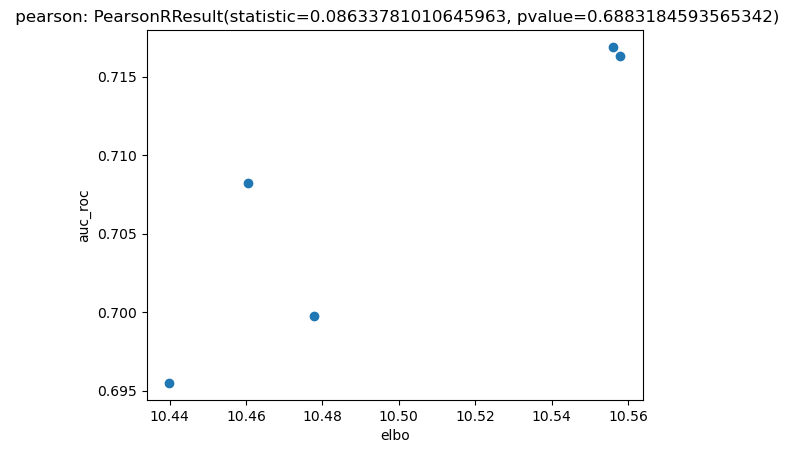

In [20]:
label_x = 'elbo' 
label_y = 'auc_roc'

plt.scatter(df_multi.head(5)[label_x], df_multi.head(5)[label_y])
plt.xlabel(label_x )
plt.ylabel(label_y)
plt.title(f" pearson: {valor_pearson}")

In [29]:
#df_multi.to_json("experiments/refine/002_validation_partial_results_29_Pima_600.json",orient="records")

In [35]:
df_multi.head(5)

,dataset,n_samples,n_features,n_anomaly,pct_anomaly,domain,kernel,batch_size,learning_rate,loss,...,n_inducing,n_epochs,elbo,auc_roc,auc_pr,training_time,inference_time,run_id,auc_roc_validation,auc_pr_validation
0,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,25,1000,10.557954,0.711054,0.569685,6.428232,0.003914,0,0.702223,0.590091
1,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,25,1000,10.557954,0.739405,0.559134,6.556753,0.006840,1,0.775598,0.645638
2,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,25,1000,10.557954,0.690532,0.532492,6.472453,0.004318,2,0.776295,0.622396
3,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,25,1000,10.557954,0.720794,0.567941,6.416835,0.006302,3,0.730508,0.524754
4,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,25,1000,10.557954,0.729468,0.562060,6.395916,0.006180,4,0.728402,0.554883


In [37]:
df_multi.head(5)[label_y]

0    0.590091
1    0.645638
2    0.622396
3    0.524754
4    0.554883
Name: auc_pr_validation, dtype: float64